In [3]:
import pandas as pd

In [ ]:
df = pd.read_csv("hf://datasets/PrkhrAwsti/Twitter_Sentiment_3M/twitter_dataset.csv")

In [4]:
df.head()

,Unnamed: 0,tweet,sentiment
0,0,is upset that he can't update his Facebook by ...,0.0
1,1,@Kenichan I dived many times for the ball. Man...,0.0
2,2,my whole body feels itchy and like its on fire,0.0
3,3,"@nationwideclass no, it's not behaving at all....",0.0
4,4,@Kwesidei not the whole crew,0.0


In [20]:
dfsample = df.sample(n=100,random_state=100)

In [21]:
dfsample.to_csv('sample_para_dashboard_prueba.csv')

In [1]:
import pandas as pd
import re
from transformers import RobertaTokenizer
import toml

# Load the dataset
secrets = toml.load(r'C:\Users\aless\Desktop\final project\Final-Project---Luis-Augustin-Ale\.streamlit\secrets.toml')
df = pd.read_csv("hf://datasets/PrkhrAwsti/Twitter_Sentiment_3M/twitter_dataset.csv")

# Clean the tweets
def clean_tweet(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'[^a-z0-9# ]', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply cleaning function to tweets
df['cleaned_tweet'] = df['tweet'].apply(clean_tweet)

# Remove neutral sentiment (class 2) to focus on binary classification (positive/negative)
df = df[df['sentiment'] != 2]

# Drop missing and duplicate values
df = df.dropna()
df = df.drop_duplicates()

# Convert sentiment column to integer
df['sentiment'] = df['sentiment'].astype(int)


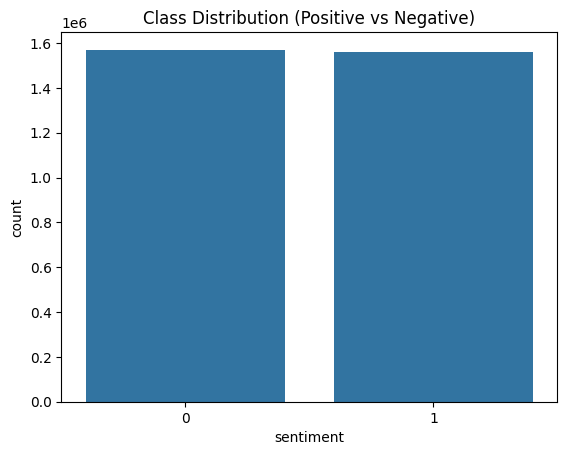

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot class distribution
sns.countplot(x='sentiment', data=df)
plt.title('Class Distribution (Positive vs Negative)')
plt.show()


In [4]:
from sklearn.utils import resample

# Separate positive and negative classes
positive = df[df['sentiment'] == 1]
negative = df[df['sentiment'] == 0]

# Oversample the minority class
if len(positive) > len(negative):
    negative = resample(negative, replace=True, n_samples=len(positive), random_state=42)
else:
    positive = resample(positive, replace=True, n_samples=len(negative), random_state=42)

# Combine the oversampled data
df = pd.concat([positive, negative])

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [8]:
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer
import torch




# Load RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Split dataset into 70% training, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(df['cleaned_tweet'], df['sentiment'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Tokenize the tweets for training, validation, and testing
def tokenize_tweet(tweet):
    tokenized_output = tokenizer(tweet, padding='max_length', truncation=True, max_length=128, return_tensors="pt")


# Tokenize the datasets
X_train_tokenized = [tokenize_tweet(tweet) for tweet in X_train]
X_val_tokenized = [tokenize_tweet(tweet) for tweet in X_val]
X_test_tokenized = [tokenize_tweet(tweet) for tweet in X_test]

# Print dataset sizes
print(f"Training set size: {len(X_train_tokenized)}")
print(f"Validation set size: {len(X_val_tokenized)}")
print(f"Test set size: {len(X_test_tokenized)}")


Training set size: 2198093
Validation set size: 471020
Test set size: 471021


In [ ]:
import torch
from transformers import RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader
import time

# Load the pre-trained RoBERTa model for binary classification
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Move model to GPU (CUDA) if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Assume train_dataset is already prepared with tokenized input_ids, attention_mask, and labels
batch_size = 16  # Define batch size for better processing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training Loop
epochs = 3  # Number of epochs
model.train()  # Set the model in training mode

for epoch in range(epochs):
    start_time = time.time()  # Track epoch start time
    running_loss = 0.0  # To accumulate loss

    for i, batch in enumerate(train_loader):
        # Move batch data to GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

        # Print progress every 100 batches
        if (i + 1) % 100 == 0:
            elapsed_time = time.time() - start_time
            print(f"Epoch {epoch + 1}/{epochs}, Step {i + 1}/{len(train_loader)}, Loss: {loss.item():.4f}, Elapsed Time: {elapsed_time:.2f} seconds")

    # Calculate average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1} completed. Avg Loss: {avg_loss:.4f}, Time Taken: {epoch_time / 60:.2f} minutes")

# Save the trained model after all epochs are complete
model.save_pretrained('./roberta_sentiment_model')
print("Model saved to './roberta_sentiment_model'.")


In [ ]:
from sklearn.metrics import accuracy_score

# Switch to evaluation mode
model.eval()

# Assume test_dataset is already prepared with tokenized input_ids, attention_mask, and labels
test_loader = DataLoader(test_dataset, batch_size=batch_size)

predictions = []
true_labels = []

with torch.no_grad():  # Disable gradient calculation for testing
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


In [ ]:
def predict_sentiment(text):
    model.eval()
    
    # Tokenize the input text
    tokenized = tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors="pt")
    input_ids = tokenized['input_ids'].squeeze().to(device)
    attention_mask = tokenized['attention_mask'].squeeze().to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0))
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).cpu().numpy()[0]

    # Convert prediction to sentiment
    sentiment = "Positive" if prediction == 1 else "Negative"
    return sentiment

# Example usage
phrase = "This product is fantastic!"
print(f"Sentiment for '{phrase}': {predict_sentiment(phrase)}")
